# ЗАДАЧА ЛАГРАНЖА

## Проектирование одноступенчатого метательного устройства на сжатом газе

In [46]:
# Импорт библиотек и модулей
import numpy as np
import matplotlib.pyplot as plt
import pylab
import matplotlib as mpl
import timeit
import pandas as pd
from tqdm import tqdm
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 

In [47]:
# Настройка шрифтов
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

## Прямая задача

In [48]:
# Пример формирования словаря с начальными данными
opts = {
    'x0': 0.1,
    'p0': 5e6,
    'm': 0.011,
    'd': 0.0145,
    'k': 1.4,
    'T0': 300,
    'R': 287,
    'stop_conditions': {'u_p_max': 125, 'x_m_max': 55*0.0145, 'p0_max': 10e6},
    'meta_parametrs': {'N': 300, 'Ku': 0.8} 
}

In [49]:
@jit(nopython=True)
def direct_task(arr_args, N=300, Ku=0.8, time_max=0.1):
    
    '''
    Функция решения прямой задачи газовой динамики в эйлеровых координатах на подвижной сетке методом AUSM+.
    
    Стоит отметить, что данная функция написана с учетом возможностей JIT (just-in-time) декоратора,
    оптимизируюшего исходный код в машинный. К примеру, невозможно было в этом случае в теле функции
    работать с такой структурой данных, как словарь, для удобства вывода результатов.
    
    !ПРИМЕЧАНИЕ!: первая прогонка этой функции проводит оптимизацию кода; при последующих запусках (что
    характерно для решения обратных задач) время выполнения ф-ции становится минимальным (порядка 0.1-0.2 секунд)
    
    args: arr_args - numpy массив с последовательными элементами: m, d, x0, p0, T0, R, k, u_p_max, x_m_max;
          N, Ku, time_max - опциональные аргументы: число ячеек, число Куранта и время вычисления
          по умолчанию: N=300, Ku=0.8, time_max=0.1 с
    :atype: numpy.ndarray
    
    return: списки распределения параметров по ячейкам в каждый момент времени: arr_x, arr_u, arr_p;
            списки осевых координат поршня, его скорости и соответствующих моментов времени: arr_x_p, arr_u_p, arr_time;
            условие остановки stop_reason (расчет идет по возможности до максимальной длины установки, если stop_reason
            в итоге == 'u_p_max', то это означает, что на данной длине устройства достигается скорость поршня больше
            либо равная заданной по условию, что является приемлемым решением)
    :rtype: list, ..., list, str
    '''
    m, d, x0, p0, T0, R, k, x_m_max = arr_args 
    
    # functions for the method:
    def f_plus(Max):  
        betta = 1 / 8
        return np.where(np.abs(Max) >= 1, (Max + np.abs(Max)) / 2, ((Max + 1) ** 2) * (1 + 4 * betta * ((Max - 1) ** 2)) / 4)
    
    def f_minus(Max):
        betta = 1 / 8
        return np.where(np.abs(Max) >= 1, (Max - np.abs(Max)) / 2, - ((Max - 1) ** 2) * (1 + 4 * betta * ((Max + 1) ** 2)) / 4)
    
    def g_plus(Max): 
        alpha = 3 / 16
        return np.where(np.abs(Max) >= 1, (Max + np.abs(Max)) / (2 * Max), ((Max + 1) ** 2) * ((2 - Max) / 4 + alpha * Max * ((Max - 1) ** 2)))

    def g_minus(Max):
        alpha = 3 / 16
        return np.where(np.abs(Max) >= 1, (Max - np.abs(Max)) / (2 * Max), ((Max - 1) ** 2) * ((2 + Max) / 4 - alpha * Max * ((Max + 1) ** 2)))
    #------------------------------------------------------------------------------------------------------------------------------------------
    # initial and boundary conditions  
    rho0 = (p0 / (R * T0))
    c0 = np.sqrt(k * p0 / rho0) 
    e0 = p0 / (rho0 * (k - 1))
    
    u_last = np.zeros(N)
    rho_last = np.zeros(N)
    e_last = np.zeros(N)
    
    for i in range(N):
        rho_last[i] = rho0
        e_last[i] = e0
    
    q1_last = rho_last
    q2_last = rho_last * u_last
    q3_last = rho_last * (e_last + (u_last ** 2) / 2)
    
    S = np.pi * d**2 / 4
    u_p = 0
    x_p = x0
    time = 0
    dx_last = x0 / N
    
    # lists for recording results
    arr_time = [time]
    arr_x = [np.linspace(0, x_p, N)]
    arr_u = [u_last]
    arr_p = [np.linspace(p0, p0, N)]
    arr_x_p = [x_p]
    arr_u_p = [u_p]

    #--------------------------------------------------
    # main loop:
    i = 0
    while x_p <= x_m_max and time <= time_max and i <= 1e4:
        #Параметры в ячейках на временном слое n
        u_last = q2_last / q1_last
        p_last = (k - 1) * (q3_last - (q2_last**2 / (2 * q1_last)))
        c_last = np.sqrt((k * p_last) / q1_last)
        H_last = (q3_last / q1_last) + (p_last / q1_last)
        # Вычисление шага по времени из условия Куранта-Фридрихса-Леви
        tau = Ku * dx_last / np.max(np.abs(u_last) + c_last)
        # Вычисление шага по пространству на временном слое n+1
        dx_new = x_p / N
        # Записываем граничные условия
        u_left = np.append(-u_last[0], u_last)
        u_right = np.append(u_last, -u_last[N-1] + 2 * u_p)
        p_left = np.append (p_last[0], p_last)
        p_right = np.append (p_last, p_last[N-1])
        c_left = np.append (c_last[0], c_last)
        c_right = np.append (c_last, c_last[N-1])
        H_left = np.append (H_last[0], H_last)
        H_right = np.append (H_last, H_last[N-1])
        q1_left = np.append (q1_last[0], q1_last)
        q1_right = np.append (q1_last, q1_last[N-1])
        q2_left = np.append (-q2_last[0], q2_last)
        q2_right = np.append (q2_last, -q2_last[N-1] + 2 * q1_last[N-1] * u_p )
        # Вычисляем давление, число Маха, скорость звука и скорость на границах ячеек (интерфейсах)
        c = (c_left + c_right) / 2
        u = np.arange(N + 1) * (u_p / N)
        M_left = (u_left - u) / c
        M_right = (u_right - u) / c
        M = f_plus(M_left) + f_minus(M_right)
        P = g_plus(M_left) * p_left + g_minus(M_right) * p_right
        # Вычисляем потоки по методу AUSM+
        f1 = ((c * (M * (q1_right + q1_left) - np.abs(M) * (q1_right - q1_left))) / 2 + 0)
        f2 = ((c * (M * (q2_right + q2_left) - np.abs(M) * (q2_right - q2_left))) / 2 + P)
        f3 = ((c * (M * (q1_right * H_right + q1_left * H_left) - np.abs(M) * (q1_right * H_right - q1_left * H_left))) / 2 + P * u)
        # Решения на временном слое n+1
        q1_last = ((dx_last / dx_new) * (q1_last - (tau / dx_last) * (f1[1:N+1] - f1[0:N])))
        q2_last = ((dx_last / dx_new) * (q2_last - (tau / dx_last) * (f2[1:N+1] - f2[0:N])))
        q3_last = ((dx_last / dx_new) * (q3_last - (tau / dx_last) * (f3[1:N+1] - f3[0:N])))
        dx_last = dx_new
        u_new = q2_last / q1_last
        p_new = (k - 1) * q1_last * ((q3_last / q1_last) - (u_new ** 2) / 2)
        u_p += (S / m) * tau * p_new[N-1]
        x_p += u_p * tau
        time += tau
        i += 0
        # Запись результатов в списки
        arr_time.append(time)
        arr_x.append(np.linspace(0, x_p, N))
        arr_u.append(u_new)
        arr_p.append(p_new)
        arr_x_p.append(x_p)
        arr_u_p.append(u_p)
    #--------------------------------------------------
    # фиксирование условия остановки
    if u_p >= u_p_max:
        stop_reason = 'u_p'
    elif x_p >= x_m_max:
        stop_reason = 'x_p'
    elif time >= time_max:
        stop_reason = 'time'
    elif i >= 1e4:
        stop_reason = 'step_max'
    else:
        stop_reason = 'unknown reason'
        
    return arr_time, arr_x, arr_u, arr_p, arr_x_p, arr_u_p, stop_reason

In [50]:
def foo(x0, p0, di=opts):
    
    '''
    Функция (пример) для решения обратной задачи газовой динамики
    args: x0, p0 - варьируемые параметры (длина камеры и давление в ней);
          opts - словарь с начальными данными (обозначаем di)
    :atype: float, float, dict
    return: res - словарь с результатами
    :rtype: dict
    '''

    def unbox_args():
        return np.array([di['m'], di['d'], di['x0'], di['p0'], di['T0'],
                         di['R'], di['k'], di['stop_conditions']['x_m_max']])
    
    di['x0'] = x0
    di['p0'] = p0
    
    arr_t, arr_x, arr_u, arr_p, arr_x_p, arr_u_p, stop_reason = direct_task(unbox_args())
    
    layers = []
    for i in range(len(arr_t)):
        dict_layer = {'t': arr_t[i], 'x': arr_x[i], 'u': arr_u[i], 'p': arr_p[i], 'x_p': arr_x_p[i], 'u_p': arr_u_p[i]}
        layers.append(dict_layer)
        
    dict_res = {
    'stop_reason': stop_reason,
    'layers': np.asarray(layers)
    }
    
    return dict_res

In [51]:
%%time
# Решение прямой задачи
result = foo(0.1, 5e6)

Wall time: 12.2 s


In [52]:
result.keys() # ключи словаря result

dict_keys(['stop_reason', 'layers'])

In [53]:
len(result['layers']) # кол-во временных слоев

3677

In [54]:
result['layers'][0]               # первый временной слой
result['layers'][-1]              # последний временной слой
t_end = result['layers'][-1]['t'] # время последнего временного слоя
print(f't = {t_end} с.') 

t = 0.006548763447001392 с.


In [55]:
# Формируем массив с времеными координатами
t_p = np.asarray([result['layers'][i]['t']*1e3 for i in range(len(result['layers']))])     # в мс
# Формируем массив с осевыми координатами, скоростями и давлениями на поршень в каждый момент времени
u_p = np.asarray([result['layers'][i]['u_p'] for i in range(len(result['layers']))])
x_p = np.asarray([result['layers'][i]['x_p'] for i in range(len(result['layers']))])
p_p = np.asarray([result['layers'][i]['p'][-1]/1e6 for i in range(len(result['layers']))]) # в МПа
# Формируем массив с давлениями на дно канала камеры установки в каждый момент времени
p_d = np.asarray([result['layers'][i]['p'][0]/1e6 for i in range(len(result['layers']))])  # в МПа

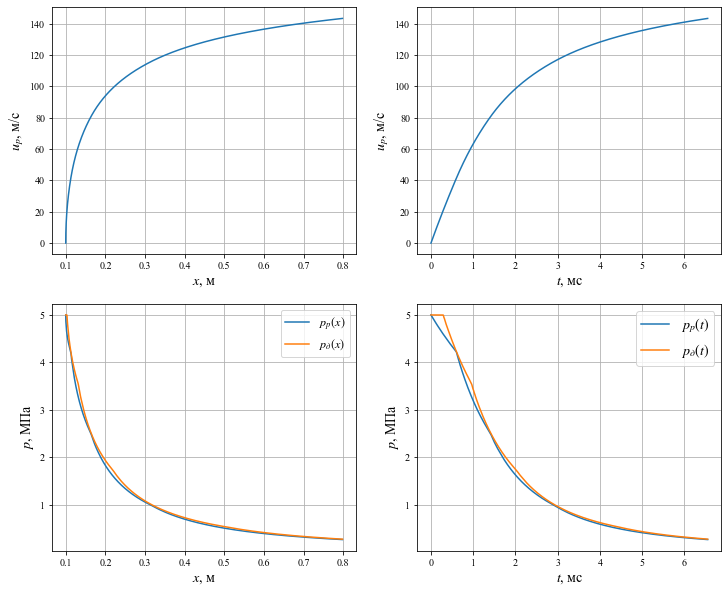

In [56]:
# Пример построения графиков
mpl.rcParams['figure.figsize'] = (12,10)

plt.subplot(221)
plt.plot(x_p, u_p)
plt.ylabel('$u_p$, м/с', fontsize=14)
plt.xlabel('$x$, м', fontsize=14)
plt.grid(True)

plt.subplot(222)
plt.plot(t_p, u_p)
plt.ylabel('$u_p$, м/с', fontsize=14)
plt.xlabel('$t$, мс', fontsize=14)
plt.grid(True)

plt.subplot(223)
plt.plot(x_p, p_p, label='$p_{p}(x)$')
plt.plot(x_p, p_d, label='$p_{д}(x)$')
plt.ylabel('$p$, МПа', fontsize=14)
plt.xlabel('$x$, м', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(224)
plt.plot(t_p, p_p, label='$p_{p}(t)$')
plt.plot(t_p, p_d, label='$p_{д}(t)$')
plt.ylabel('$p$, МПа', fontsize=14)
plt.xlabel('$t$, мс', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)

plt.savefig('4 графика.png', dpi=600, bbox_inches='tight')

plt.show()

## Обратная задача

In [57]:
d = opts['d']
S = np.pi * d**2 / 4
m = opts['m']
k = opts['k']
@jit(nopython=True)
def target_foo(x0, p0, u_p):
    '''
    Целевая ф-ция для оптимизации решений (к примеру, была выбрана ф-ция КПД метательной установки)
    args: x0 - длина камеры, p0 - давление в камере, u_p - скорость поршня в момент вылета
    :atype: float, float, float
    return: значение КПД, %
    :rtype: float
    '''
    return 0.5 * (k - 1) * ((m * u_p**2) / (p0 * x0 * S)) * 100

In [58]:
x_m_max = opts['stop_conditions']['x_m_max']
u_p_max = opts['stop_conditions']['u_p_max']
p0_max  = opts['stop_conditions']['p0_max']
x0_max = x_m_max / 3
x0_min = 0.1 * x0_max
p0_min = 0.1 * p0_max
N = 30  # "грубая" сетка
x0 = np.linspace(x0_min, x0_max, N) # массив варьируемой длины камеры
p0 = np.linspace(p0_min, p0_max, N) # массив варьируемого давления в камере
# списки-list для записи всех результатов    
arr_x     = []                          
arr_p     = []
arr_tf    = []
arr_u_p   = []
arr_label = []

In [59]:
# Перебор параметров (обратная задача решается методом полного перебора)
time_start = timeit.default_timer() #таймер
for i in tqdm(range(0,N)):    
    for j in range(0,N):
        res = foo(x0[i], p0[j])
        u_p = res['layers'][-1]['u_p']
        if (u_p >= u_p_max):
            Label = True
        else:
            Label = False
        arr_tf.append(target_foo(x0[i], p0[j], u_p))
        arr_x.append(x0[i])
        arr_p.append(p0[j])
        arr_u_p.append(u_p)
        arr_label.append(Label)
time_end = timeit.default_timer() - time_start
print(f'Время выполнения перебора: \n{time_end} cек\n   или   \n{time_end/60} мин')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:39<00:00,  9.31s/it]

Время выполнения перебора: 
279.3908943000006 cек
   или   
4.65651490500001 мин


In [60]:
# Запишем в файл data_set.xlsx
dict_sort = {
    'x0': arr_x,
    'p0': arr_p,
    'u_p': arr_u_p,
    'label': arr_label,
    'tf': arr_tf
}
df = pd.DataFrame(dict_sort)
df.to_excel('data_set.xlsx', 'sorting', index=False)

In [61]:
# Прочитать данные из файла в случае необходимости
df = pd.read_excel('data_set.xlsx', 'sorting')
df

,x0,p0,u_p,label,tf
0,0.026583,1.000000e+06,38.492115,False,74.255890
1,0.026583,1.310345e+06,44.048197,False,74.209248
2,0.026583,1.620690e+06,48.973517,False,74.166893
3,0.026583,1.931034e+06,53.446339,False,74.136701
4,0.026583,2.241379e+06,57.569804,False,74.107388
...,...,...,...,...,...
895,0.265833,8.758621e+06,234.651221,True,31.506291
896,0.265833,9.068966e+06,238.375039,True,31.401555
897,0.265833,9.379310e+06,242.138554,True,31.328842
898,0.265833,9.689655e+06,245.744135,True,31.235277


In [62]:
# Отбираем те решения, которые дают необходимую скорость вылета поршня
df_true = df.loc[df['label'] == True]
df_true

,x0,p0,u_p,label,tf
55,0.034833,8.758621e+06,126.788035,True,70.197652
56,0.034833,9.068966e+06,128.965480,True,70.144071
57,0.034833,9.379310e+06,131.119476,True,70.107627
58,0.034833,9.689655e+06,133.232116,True,70.066639
59,0.034833,1.000000e+07,135.319490,True,70.036182
...,...,...,...,...,...
895,0.265833,8.758621e+06,234.651221,True,31.506291
896,0.265833,9.068966e+06,238.375039,True,31.401555
897,0.265833,9.379310e+06,242.138554,True,31.328842
898,0.265833,9.689655e+06,245.744135,True,31.235277


## Задача баллистического проектирования

In [67]:
# Ищем максимальное значение целевой функции target foo (tf)
ind_max = df_true['tf'].idxmax()
x0_opt = df_true['x0'][ind_max]
p0_opt = df_true['p0'][ind_max]
tf_opt = df_true['tf'][ind_max]
x0_opt, p0_opt, tf_opt

(0.03483333333333333, 8758620.689655174, 70.19765163922713)

In [ ]:
# Уточнение найденного значения целевой функции путем построения более регулярной сетки
p_error, x_error = 1e3, 1e-3 # Точность решения 1кПа по давлению в камере и 1 мм по её длине
C = 31                       # кол-во узлов сетки
counter = 0                  # счетчик кол-ва уточнений
flag = False
while flag == False:
    x0_grid = np.linspace(x0_opt - x_error*(C-1)/2, x0_opt + x_error*(C-1)/2, C)
    p0_grid = np.linspace(p0_opt - p_error*(C-1)/2, p0_opt + p_error*(C-1)/2, C)
    flag_correct = False  
    arr_label = []
    arr_tf = []
    arr_x0 = []
    arr_p0 = []
    counter += 1  
    for i in tqdm(range(len(x0_grid))):
        for j in range(len(p0_grid)):
            res = foo(x0_grid[i], p0_grid[j])
            u_p = res['layers'][-1]['u_p']
            if (u_p >= u_p_max):
                Label = True
            else:
                Label = False
            arr_label.append(Label)
            arr_tf.append(target_foo(x0_grid[i], p0_grid[j], u_p))
            arr_x0.append(x0_grid[i])
            arr_p0.append(p0_grid[j])
    for l in range(len(arr_label)):
        if (arr_label[l] == True) and (arr_tf[l] < tf_opt):
            tf_opt = arr_tf[l]
            x0_opt = arr_x0[l]
            p0_opt = arr_p0[l]
            flag_correct = True 
    print(x0_opt,p0_opt,tf_opt,counter)
    if flag_correct == False:
        flag = True

In [ ]:
# Визуализируем данные
N = len(df['x0'])
X, Y = np.meshgrid(df['x0'], df['p0'])
Z = np.empty([N, N])

In [ ]:
for i in tqdm(range(N)):    
    for j in range(N):
        res = foo(X[0][j], Y[i][0])
        u_p = res['layers'][-1]['u_p']
        Z[i][j] = (target_foo(X[0][j], Y[i][0], u_p))

In [ ]:
fig = pylab.figure()
axes = Axes3D(fig)
axes.plot_surface(X, Y, Z, rstride = 3, cstride = 3, cmap = cm.viridis) 
axes.set_xlabel("$p$, $Па$")
axes.set_ylabel("$x0$, $м$")
axes.set_zlabel("$\eta$, %")
pylab.show()

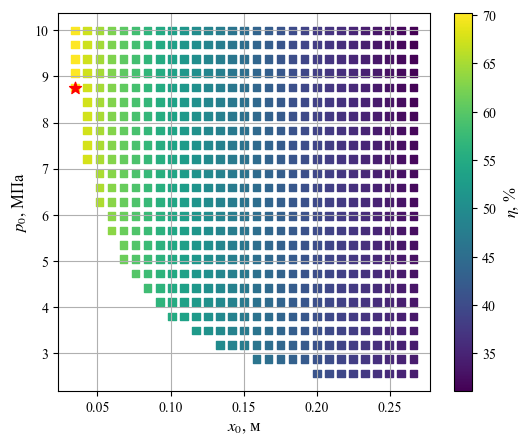

In [95]:
plt.figure(figsize=(6,5), dpi=100)
plt.xlabel('$x_{0}$, м', fontsize = 12)
plt.ylabel('$p_{0}$, МПа', fontsize = 12)
cb = plt.scatter(df_true['x0'], df_true['p0']/1e6, c=df_true['tf'], cmap=cm.viridis, s=30,marker='s')
plt.colorbar(cb).set_label(r'$\eta$, %',fontsize=12)
plt.scatter(x0_opt,p0_opt/1e6,s=80, color='r',marker='*')
plt.grid()
plt.show()

In [74]:
# Решение прямой задачи для оптимального варианта
%time res = foo(x0_opt, p0_opt)

Wall time: 470 ms


In [90]:
from IPython.display import display
from ipywidgets import interact
#-------------------------------------------------------------------
# Распределение газодинамических параметров на временных слоях
#-------------------------------------------------------------------
count_layers = len(res['layers'])-1
@interact(function=['p(x)', 'u(x)'])
def foo_lang(function):
    #------------------------
    if function == 'p(x)':
        @interact(layer=(0,count_layers,1))
        def plot_foo1(layer=0):
            plt.figure(figsize=(7,5))
            plt.plot(res['layers'][layer]['x'], res['layers'][layer]['p']/1e6)
            plt.xlim(0, x_m_max)
            plt.ylim(0, (p0_max+1e6)/1e6)
            plt.title('$p(x)$')
            plt.grid()
            plt.show()
    #------------------------
    if function == 'u_p(x)':
        @interact(layer=(0,count_layers,1))
        def plot_foo2(layer=0):
            plt.figure(figsize=(7,5))
            plt.plot(res['layers'][layer]['x'], res['layers'][layer]['u'])
            lt.xlim(0, x_m_max)
            plt.ylim(0, res['layers'][-1]['u_p'])
            plt.title('$u(x)$')
            plt.grid()
            plt.show()

interactive(children=(Dropdown(description='function', options=('p(x)', 'u(x)'), value='p(x)'), Output()), _do…